# Dependence

In [10]:
import torch
import torch.nn as nn
import torch.autograd as autograd

import numpy as np 

from pyDOE import lhs

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter

In [11]:
steps = 10000
layers = np.array([2,32,64,32,2])
lr = 0.001

Nf = 20000

# Auxiliary Functions


In [12]:
def Plot(V,tris,U):
    fig,ax=plt.subplots()
    colors=ax.tripcolor(V[:,0],V[:,1],tris,U,cmap='viridis')
    fig.colorbar(colors)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('U')
    plt.show()

# Build initial physical mesh and logical mesh

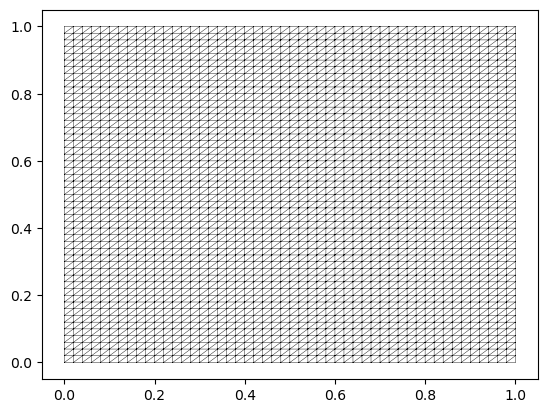

In [13]:
m_rows = 50
m_cols = 50

x = torch.linspace(0, 1, m_cols + 1)
y = torch.linspace(0, 1, m_rows + 1)
x = x.repeat(m_rows + 1)
y = y.repeat_interleave(m_cols + 1)
V_0 = torch.stack([x,y],dim=1) #physical mesh
V_xi_0 = V_0.clone() #logical mesh

tris = []

for i in range(m_cols):
   for j in range(m_rows):
       tris.append([j * (m_cols + 1) + i, j * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i + 1])
       tris.append([j * (m_cols + 1) + i, (j + 1) * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i])
        
tris = torch.tensor(tris, dtype=torch.short)

plt.triplot(x,y,tris,'k-',linewidth=0.3)
plt.show()

# Functions

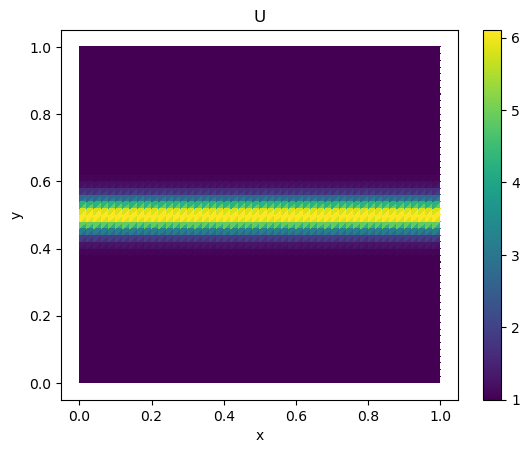

In [14]:
# def U(V):
#     return torch.tanh(-30*(V[:,[1]]-0.5-0.25*torch.sin(2*torch.pi*V[:,[0]])))

# def U_x_y(V):
#     u_x = (1-U(V)**2)*(15*torch.pi*torch.cos(2*torch.pi*V[:,[0]]))
#     u_y = (1-U(V)**2)*(-30)
#     return torch.cat([u_x,u_y],dim=1)

def U(V):
    return torch.tanh(20*(V[:,[1]]-0.5))

def U_x_y(V):
    u_y = (1-U(V)**2)*20
    u_x = torch.zeros_like(u_y)
    return torch.cat([u_x,u_y],dim=1)

def Metric(V):
    u_x_y = U_x_y(V)
    return torch.sqrt(0.1*torch.linalg.norm(u_x_y,dim=1)**2 + 1)

M = Metric(V_0)
Plot(V_0.detach().cpu(),tris.detach().cpu(),M.detach().cpu())

# Neural Network generates harmonic maps

$$
\begin{cases}
-\nabla \cdot (\frac{1}{M(x)}\nabla \xi) = 0, \\
\xi|_{\partial \Omega} = \xi_b,
\end{cases}\\
$$

$$
M(x) = \sqrt{1+0.1||\nabla u||_2^2}
$$


In [15]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.loss_function2 = nn.L1Loss(reduction ='sum')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)
        a = self.linears[-1](a)
        a[:,[0]] = a[:,[0]]*(x[:,[0]])*(1-x[:,[0]]) + x[:,[0]]
        a[:,[1]] = a[:,[1]]*(x[:,[1]])*(1-x[:,[1]]) + x[:,[1]]
        # a[:,[0]] = a[:,[0]]*(x[:,[0]])*torch.sin(torch.pi*x[:,[0]]) + torch.sin(torch.pi/2.0*x[:,[0]])
        # a[:,[1]] = a[:,[1]]*(x[:,[1]])*torch.sin(torch.pi*x[:,[1]]) + torch.sin(torch.pi/2.0*x[:,[1]])
        return a    
    
    def loss_BC(self,left_V,right_V,bottom_V,top_V):
        return self.loss_function2(self.forward(left_V)[:,[0]],torch.zeros([left_V.shape[0],1]).to(device)) + \
               self.loss_function2(self.forward(right_V)[:,[0]],torch.ones([right_V.shape[0],1]).to(device)) + \
               self.loss_function2(self.forward(bottom_V)[:,[1]],torch.zeros([bottom_V.shape[0],1]).to(device)) + \
               self.loss_function2(self.forward(top_V)[:,[1]],torch.ones([top_V.shape[0],1]).to(device))
    
    def loss_PDE(self,PDE_V):
        g = PDE_V.clone()
        g.requires_grad = True
        f = self.forward(g)
        M = Metric(g).unsqueeze(1)
        nabla_f0 =  autograd.grad(f[:,[0]],g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        nabla_f1 =  autograd.grad(f[:,[1]],g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        F0 = autograd.grad(nabla_f0/M,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        F1 = autograd.grad(nabla_f1/M,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        return self.loss_function(F0[:,[0]]+F0[:,[1]],torch.zeros([g.shape[0],1]).to(device)) + \
               self.loss_function(F1[:,[0]]+F1[:,[1]],torch.zeros([g.shape[0],1]).to(device))

    def loss(self,PDE_V,left_V,right_V,bottom_V,top_V):      
        return self.loss_PDE(PDE_V)
        #return self.loss_PDE(PDE_V) + self.loss_BC(left_V,right_V,bottom_V,top_V)
    
    def closure(self):
        optimizer_lbfgs.zero_grad()
        loss = self.loss(PDE_V,left_V,right_V,bottom_V,top_V)
        loss.backward()
        self.iter += 1
        return loss
    

# Training Data

In [16]:
left_V = V_0[(V_0[:,0]==0.0)]
right_V = V_0[(V_0[:,0]==1.0)]
bottom_V = V_0[(V_0[:,1]==0.0)]
top_V = V_0[(V_0[:,1]==1.0)]

PDE_V = V_0[0] + (V_0[-1]-V_0[0])*lhs(2,Nf)
PDE_V = torch.vstack((left_V,right_V,bottom_V,top_V,PDE_V))

left_V = left_V.to(device) 
right_V = right_V.to(device) 
bottom_V = bottom_V.to(device) 
top_V = top_V.to(device) 
V_0 = V_0.to(device)
V_xi_0 = V_xi_0.to(device)
PDE_V = PDE_V.float().to(device)

C:\Users\13162\AppData\Local\Temp\ipykernel_13780\2378226178.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  PDE_V = V_0[0] + (V_0[-1]-V_0[0])*lhs(2,Nf)


# Generate harmonic maps

adam 0 35.07719
adam 1 33.178688
adam 2 31.526962
adam 3 30.108675
adam 4 28.905424
adam 5 27.894522
adam 6 27.05312
adam 7 26.359587
adam 8 25.792368
adam 9 25.32901
adam 10 24.946173
adam 11 24.620369
adam 12 24.32921
adam 13 24.05294
adam 14 23.775927
adam 15 23.487713
adam 16 23.18332
adam 17 22.86279
adam 18 22.530138
adam 19 22.192009
adam 20 21.856302
adam 21 21.530952
adam 22 21.22298
adam 23 20.937836
adam 24 20.679028
adam 25 20.448017
adam 26 20.24434
adam 27 20.06594
adam 28 19.909628
adam 29 19.77166
adam 30 19.648338
adam 31 19.536518
adam 32 19.433979
adam 33 19.339539
adam 34 19.252926
adam 35 19.174515
adam 36 19.104956
adam 37 19.044893
adam 38 18.994743
adam 39 18.95457
adam 40 18.923973
adam 41 18.901993
adam 42 18.88702
adam 43 18.87684
adam 44 18.868912
adam 45 18.860775
adam 46 18.850544
adam 47 18.83725
adam 48 18.820889
adam 49 18.802246
adam 50 18.78251
adam 51 18.762932
adam 52 18.744553
adam 53 18.728077
adam 54 18.713848
adam 55 18.701843
adam 56 18.691738


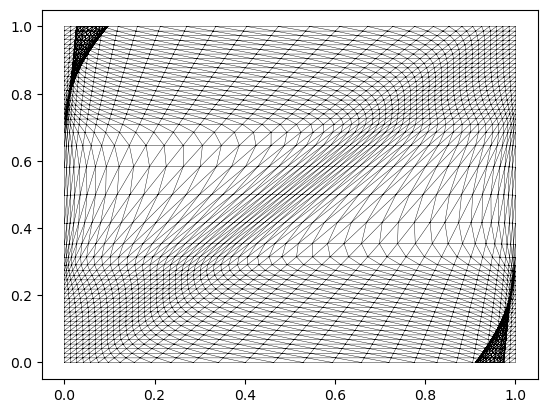

In [ ]:
F_xi = FCN(layers).to(device)
optimizer = torch.optim.Adam(F_xi.parameters(),lr=lr,amsgrad=False)

best_loss = 1e10
adam_early_stop = 50
early_stop_count = 0
early_stop_step = 0
optimizer_adam = torch.optim.Adam(F_xi.parameters(),lr=lr,amsgrad=False)
for i in range(steps):
    loss = F_xi.loss(PDE_V, left_V, right_V, bottom_V, top_V)
    optimizer_adam.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(xi_new.parameters(), 1.0)
    optimizer_adam.step()
    if(loss.detach().cpu().numpy() < best_loss):
        best_loss = loss.detach().cpu().numpy()
        print('adam', i, best_loss)
        early_stop_count = 0
    else:
        early_stop_count += 1
    if early_stop_count > adam_early_stop:
        early_stop_step = i
        break
    
if early_stop_step != 0:
    optimizer_lbfgs = torch.optim.LBFGS(F_xi.parameters(), lr=1.0, max_iter=10, history_size=50)
    for i in range(early_stop_step,steps):
        loss = optimizer_lbfgs.step(F_xi.closure)
        print('lbfgs', i,loss.detach().cpu().numpy())
    
V_xi_new = F_xi(V_0)
plt.triplot(V_xi_new.detach().cpu()[:,0],V_xi_new.detach().cpu()[:,1],tris.detach().cpu(),'k-',linewidth=0.3)

# Update physical mesh

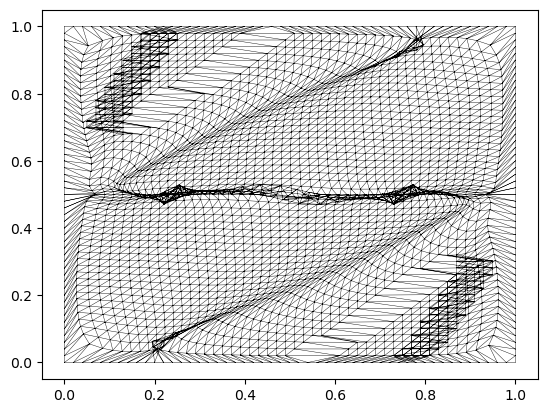

In [18]:
V_0_clone = V_0.clone()
V_0_clone.requires_grad = True
V_xi_new = F_xi(V_0_clone)

xi_x_y = autograd.grad(V_xi_new[:,0].unsqueeze(1),V_0_clone,torch.ones([V_0_clone.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
eta_x_y = autograd.grad(V_xi_new[:,1].unsqueeze(1),V_0_clone,torch.ones([V_0_clone.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
xi_x,xi_y,eta_x,eta_y = xi_x_y[:,[0]],xi_x_y[:,[1]],eta_x_y[:,[0]],eta_x_y[:,[1]]
delta_V_xi = V_xi_0 - V_xi_new
delta_V_x = 1/(xi_x*eta_y-xi_y*eta_x)*(eta_y*delta_V_xi[:,[0]]-xi_y*delta_V_xi[:,[1]])
delta_V_y = 1/(xi_x*eta_y-xi_y*eta_x)*(-eta_x*delta_V_xi[:,[0]]+xi_x*delta_V_xi[:,[1]])
delta_V = torch.cat((delta_V_x,delta_V_y),dim=1)
delta_V = delta_V / torch.linalg.norm(delta_V,dim=1).unsqueeze(1)*0.05
delta_V[V_0_clone[:,0]==0.0] = 0.0
delta_V[V_0_clone[:,0]==1.0] = 0.0
delta_V[V_0_clone[:,1]==0.0] = 0.0
delta_V[V_0_clone[:,1]==1.0] = 0.0

new_V = (V_0_clone + delta_V)

plt.triplot(new_V.detach().cpu()[:,0],new_V.detach().cpu()[:,1],tris.detach().cpu(),'k-',linewidth=0.3)
plt.show()